# Glassdoor Reviews Report

- [Matplotlib List of named colors](https://matplotlib.org/stable/gallery/color/named_colors.html)

## Local imports config

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

## General imports

In [2]:
import collections
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import re
import seaborn as sns
import torch
import warnings

from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from utils.plot_config import PlotConfig
from wordcloud import WordCloud

In [3]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [4]:
sns.set_palette(sns.color_palette())

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce GTX 1650


In [6]:
def remove_special_characters(text: str) -> str:
    # maybe we can replace all the regex to this: re.sub("[^A-Za-z']+"

    cleaned_text = re.sub(r"[0-9]+", " ", text)  # replace numbers to space
    cleaned_text = re.sub(
        r"\s+", " ", cleaned_text
    )  # replace multiple spaces to single space
    cleaned_text = re.sub(r"\n", " ", cleaned_text)  # replace breakline to single space
    cleaned_text = re.sub(r"\n", " ", cleaned_text)  # replace breakline to single space
    cleaned_text = re.sub(
        r"[@#$%&*()?_<>!=':º°–~—±ñ\"\,\.\[\]\/\\;-]", " ", cleaned_text
    )  # replace special characters to single space

    # cleaned_text = re.sub(r"[^\w\sa-zA-Z]", " ", text)
    cleaned_text = cleaned_text.lower()

    return cleaned_text

In [7]:
reviews_df = pd.read_csv("./glassdoor_reviews_predicted.csv")

In [8]:
reviews_df.shape

(2532, 10)

In [9]:
reviews_df["predicted_sentiment"].value_counts()

predicted_sentiment
1    1274
2    1004
0     254
Name: count, dtype: int64

In [10]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2532 entries, 0 to 2531
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   review_id            2532 non-null   int64  
 1   company              2532 non-null   object 
 2   employee_role        2532 non-null   object 
 3   employee_detail      2532 non-null   object 
 4   review_text          2532 non-null   object 
 5   review_date          2532 non-null   object 
 6   star_rating          2532 non-null   float64
 7   sentiment            2532 non-null   int64  
 8   annotated            2532 non-null   int64  
 9   predicted_sentiment  2532 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 197.9+ KB


In [11]:
reviews_df.head(2)

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated,predicted_sentiment
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",2023-12-15,5.0,1,0,1
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,2023-12-15,5.0,0,1,0


In [12]:
neutral_reviews_df = reviews_df[reviews_df["predicted_sentiment"] == 0]
positive_reviews_df = reviews_df[reviews_df["predicted_sentiment"] == 1]
negative_reviews_df = reviews_df[reviews_df["predicted_sentiment"] == 2]

### Stopwords

In [13]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stevi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stopwords_portuguese = nltk.corpus.stopwords.words("portuguese")

In [15]:
stopwords_portuguese.append("empresa")

In [16]:
"empresa" in stopwords_portuguese

True

## N-Grams

In [17]:
def plot_top_ngrams_barchart(review_text, n_grams=2, top=10, title=None):
    vec = CountVectorizer(ngram_range=(n_grams, n_grams)).fit(review_text)
    bag_of_words = vec.transform(review_text)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    top_n_grams = words_freq[:top]
    x, y = map(list, zip(*top_n_grams))

    sns.barplot(x=y, y=x)
    plt.title(title, fontsize=20)

### Positive

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


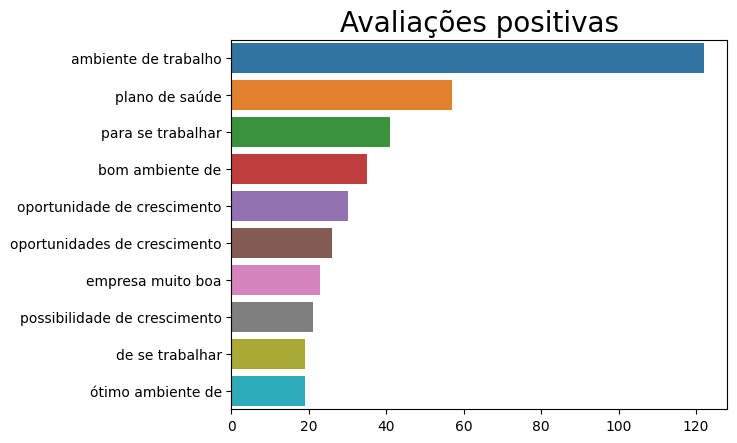

In [18]:
plot_top_ngrams_barchart(
    positive_reviews_df["review_text"],
    n_grams=3,
    top=10,
    title="Avaliações positivas",
)

#### Negative N-Grams

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


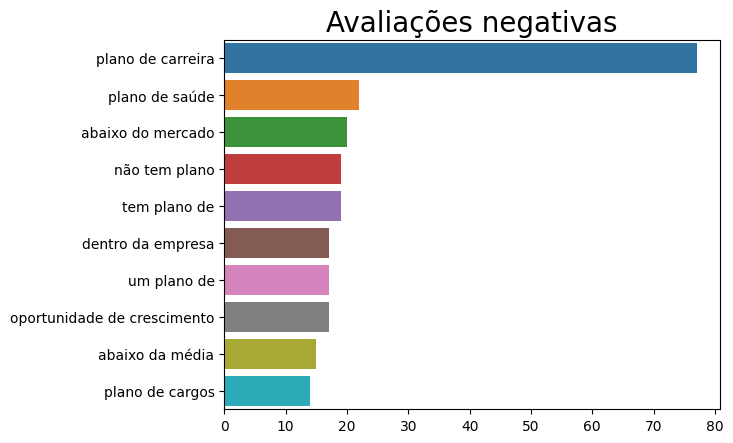

In [19]:
plot_top_ngrams_barchart(
    negative_reviews_df["review_text"],
    n_grams=3,
    top=10,
    title="Avaliações negativas",
)

#### Neutral N-Grams

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


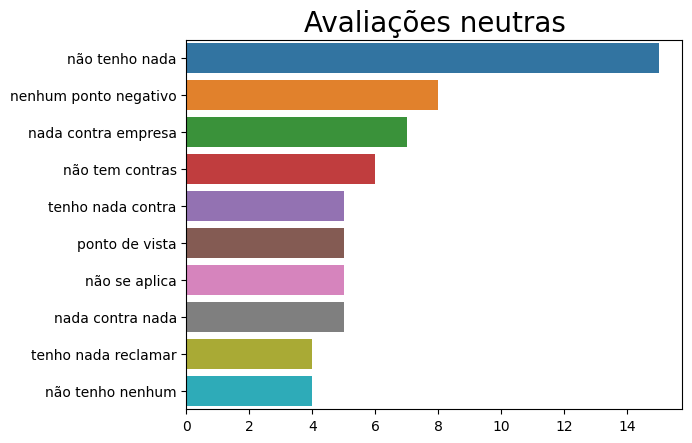

In [20]:
plot_top_ngrams_barchart(
    neutral_reviews_df["review_text"],
    n_grams=3,
    top=10,
    title="Avaliações neutras",
)

## WordCloud

In [21]:
def print_wordcloud(corpus, title=None, max_words=30, color_title="black"):
    non_stopwords_corpus = []
    for word in corpus:
        word_lower = word.lower()
        if (
            word_lower not in stopwords_portuguese
            and word_lower not in punctuation
        ):
            non_stopwords_corpus.append(word_lower)

    non_stopwords_corpus_str = " ".join(non_stopwords_corpus)

    wordcloud = WordCloud(
        background_color="white",
        random_state=PlotConfig.RANDOM_SEED,
        max_words=max_words,
        width=1024,
        height=768,
    )

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis("off")

    plt.imshow(wordcloud.generate(str(non_stopwords_corpus_str)))
    plt.title(title, fontsize=20, color=color_title)
    plt.show()

All Reviews' Sentiment


In [22]:
nested_reviews = reviews_df["review_text"].str.split().values.tolist()
reviews_str = " ".join([" ".join(nested_review) for nested_review in nested_reviews])
corpus = remove_special_characters(reviews_str).split()

In [23]:
word_freq = collections.Counter(corpus)
print(word_freq)

Counter({'de': 2145, 'e': 1326, 'empresa': 862, 'a': 841, 'não': 686, 'para': 648, 'o': 638, 'que': 600, 'com': 519, 'em': 465, 'muito': 428, 'é': 375, 'trabalho': 371, 'os': 321, 'da': 321, 'ambiente': 320, 'tem': 288, 'se': 284, 'um': 279, 'do': 277, 'benefícios': 260, 'salário': 251, 'uma': 245, 'crescimento': 244, 'plano': 240, 'bom': 240, 'no': 231, 'na': 210, 'boa': 190, 'trabalhar': 184, 'funcionários': 178, 'falta': 165, 'por': 164, 'as': 160, 'carreira': 154, 'mais': 152, 'dos': 152, 'bem': 150, 'colaboradores': 150, 'são': 149, 'oportunidade': 145, 'pessoas': 135, 'mercado': 129, 'dia': 122, 'sem': 119, 'nada': 119, 'como': 113, 'ser': 103, 'equipe': 101, 'alimentação': 101, 'oportunidades': 99, 'ótima': 97, 'sempre': 97, 'profissional': 96, 'ao': 95, 'gestão': 95, 'saúde': 92, 'desenvolvimento': 92, 'alguns': 90, 'mas': 89, 'vale': 88, 'ou': 86, 'funcionário': 86, 'pouco': 82, 'bons': 80, 'grande': 79, 'entre': 76, 'excelente': 75, 'gestores': 75, 'estrutura': 73, 'horário':

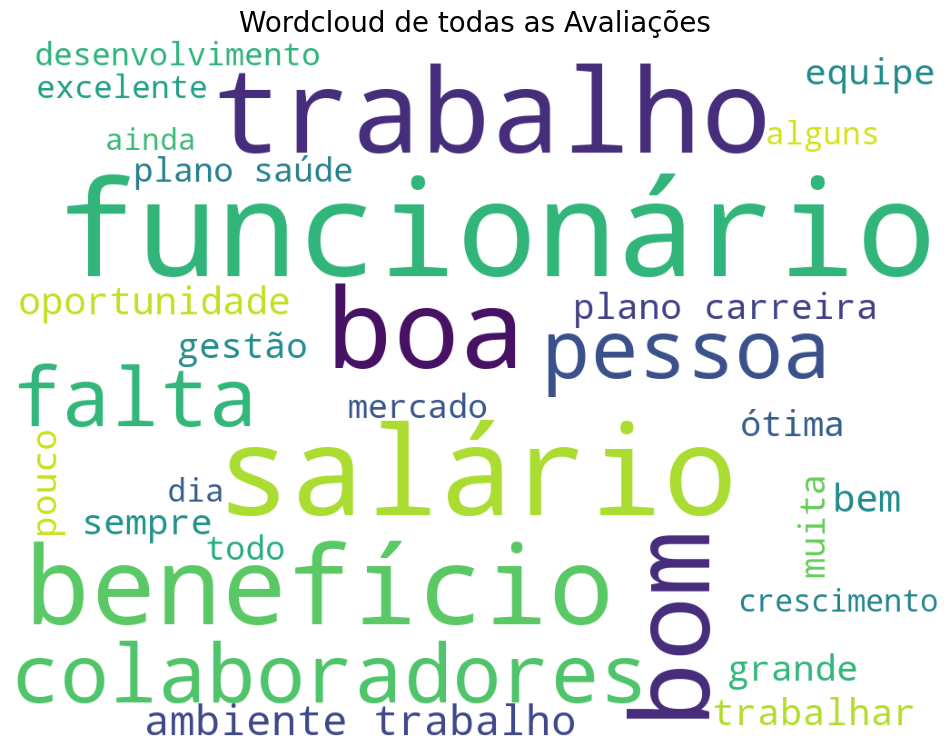

In [24]:
nested_reviews = reviews_df["review_text"].str.split().values.tolist()
reviews_str = " ".join([" ".join(nested_review) for nested_review in nested_reviews])
corpus = remove_special_characters(reviews_str).split()

print_wordcloud(corpus, title="Wordcloud de todas as Avaliações")

#### Positive WordCloud

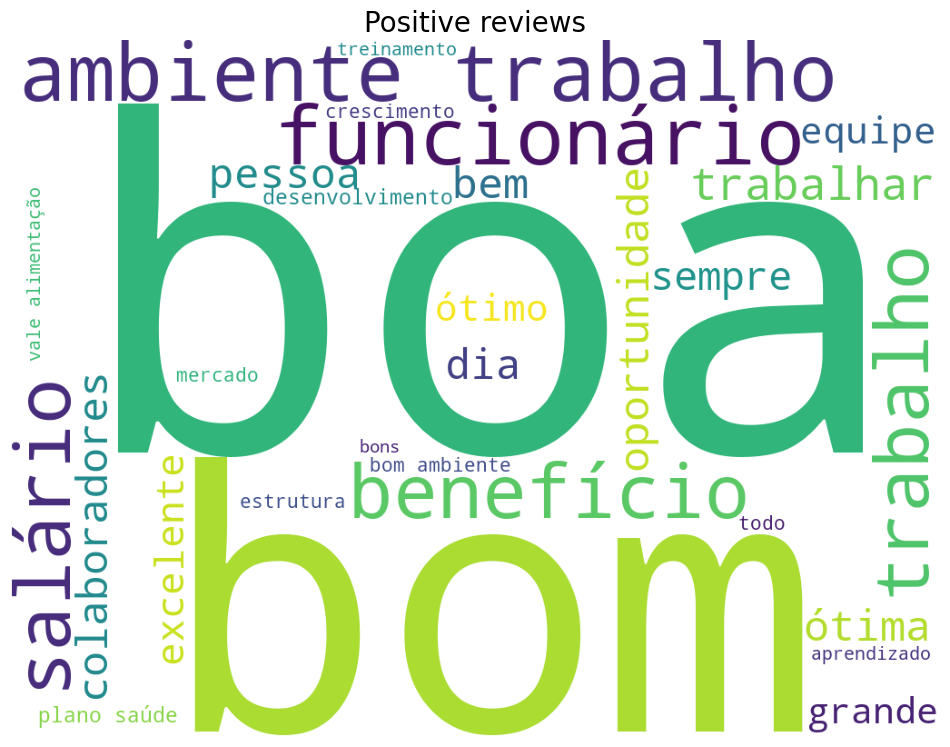

In [25]:
nested_reviews = positive_reviews_df["review_text"].str.split().values.tolist()
reviews_str = " ".join([" ".join(nested_review) for nested_review in nested_reviews])
corpus = remove_special_characters(reviews_str).split()

print_wordcloud(corpus, title="Positive reviews")

#### Negative WordCloud

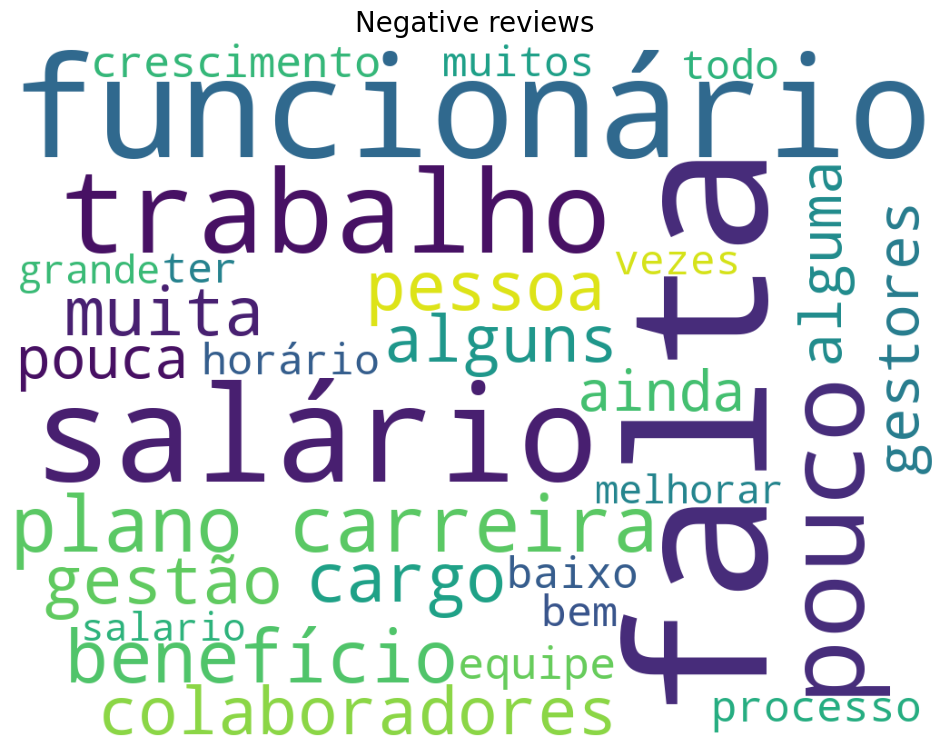

In [26]:
nested_reviews = negative_reviews_df["review_text"].str.split().values.tolist()
reviews_str = " ".join([" ".join(nested_review) for nested_review in nested_reviews])
corpus = remove_special_characters(reviews_str).split()

print_wordcloud(corpus, title="Negative reviews")

#### Neutral WordCloud

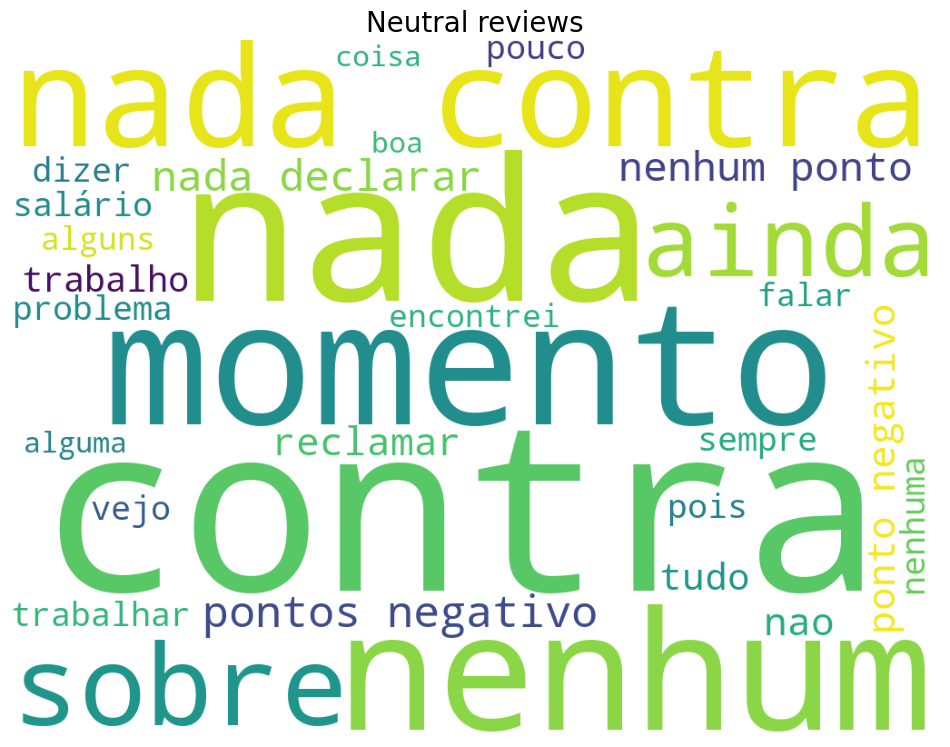

In [27]:
nested_reviews = neutral_reviews_df["review_text"].str.split().values.tolist()
reviews_str = " ".join([" ".join(nested_review) for nested_review in nested_reviews])
corpus = remove_special_characters(reviews_str).split()

print_wordcloud(corpus, title="Neutral reviews")

### All in One

In [28]:
def get_reviews_corpus(reviews):
    nested_reviews = reviews.str.split().values.tolist()
    reviews_str = " ".join(
        [" ".join(nested_review) for nested_review in nested_reviews]
    )
    reviews_corpus = remove_special_characters(reviews_str).split()

    return reviews_corpus

In [29]:
def get_non_stopwords_corpus(corpus):
    non_stopwords_corpus = []
    for word in corpus:
        word_lower = word.lower()
        if (
            word_lower not in stopwords_portuguese
            and word_lower not in punctuation
        ):
            non_stopwords_corpus.append(word_lower)

    non_stopwords_corpus_str = " ".join(non_stopwords_corpus)
    return non_stopwords_corpus_str

In [30]:
all_reviews_corpus = get_reviews_corpus(reviews_df["review_text"])
positive_reviews_corpus = get_reviews_corpus(positive_reviews_df["review_text"])
negative_reviews_corpus = get_reviews_corpus(negative_reviews_df["review_text"])
neutral_reviews_corpus = get_reviews_corpus(neutral_reviews_df["review_text"])

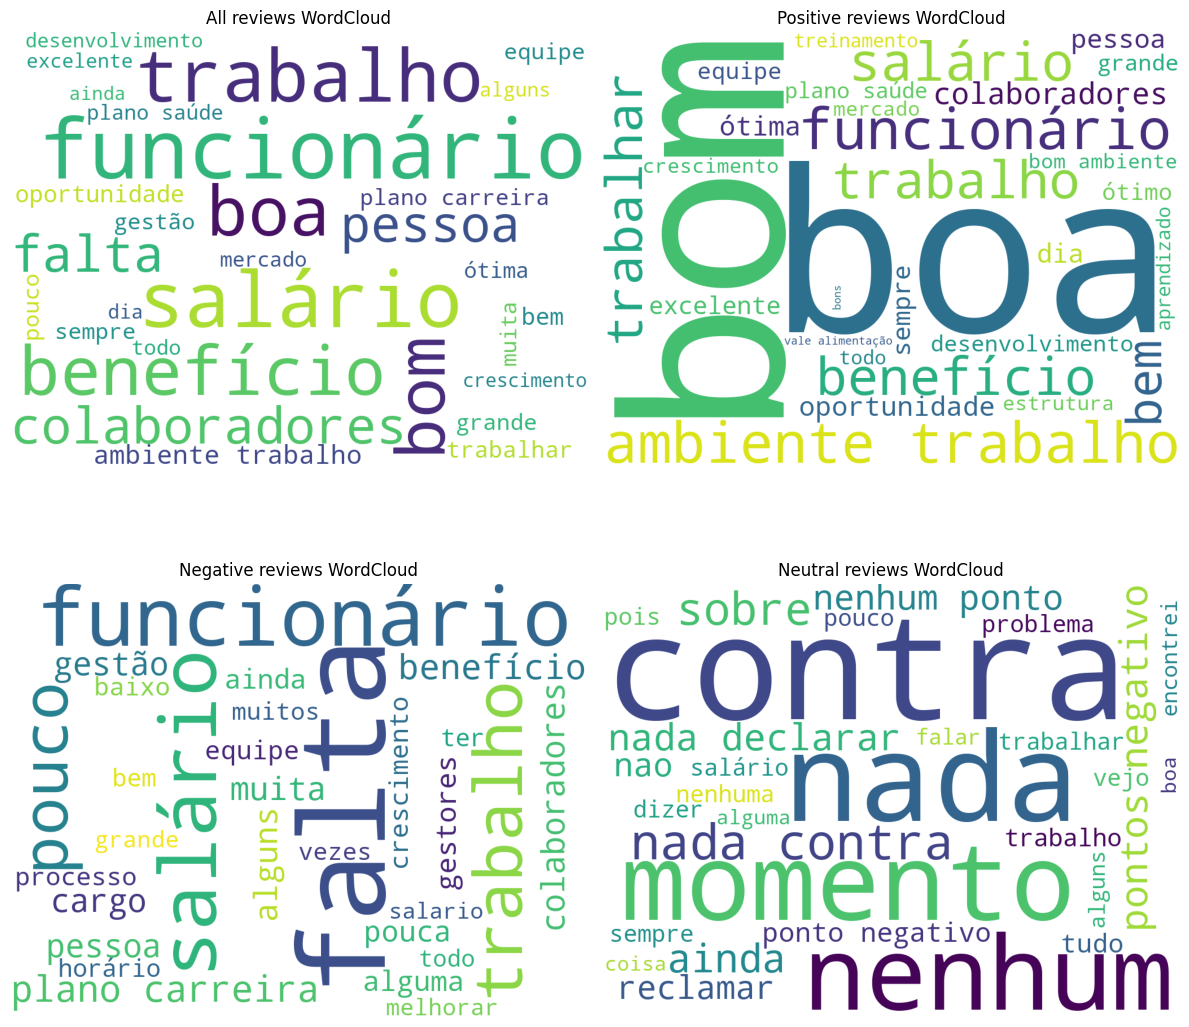

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

wordcloud = WordCloud(
    background_color="white",
    random_state=PlotConfig.RANDOM_SEED,
    max_words=30,
    width=1024,
    height=768,
)

ax[0, 0].imshow(wordcloud.generate(str(get_non_stopwords_corpus(all_reviews_corpus))))
ax[0, 0].set_title("All reviews WordCloud")
ax[0, 0].axis("off")

# Positive
ax[0, 1].imshow(
    wordcloud.generate(str(get_non_stopwords_corpus(positive_reviews_corpus)))
)
ax[0, 1].set_title("Positive reviews WordCloud")
ax[0, 1].axis("off")

# Negative
ax[1, 0].imshow(
    wordcloud.generate(str(get_non_stopwords_corpus(negative_reviews_corpus)))
)
ax[1, 0].set_title("Negative reviews WordCloud")
ax[1, 0].axis("off")

# Neutral
ax[1, 1].imshow(
    wordcloud.generate(str(get_non_stopwords_corpus(neutral_reviews_corpus)))
)
ax[1, 1].set_title("Neutral reviews WordCloud")
ax[1, 1].axis("off")

plt.tight_layout()
plt.show()

## Sentiment statistics

### Predicted Sentiment Distribution

In [32]:
sentiment_counts = reviews_df["predicted_sentiment"].value_counts().reset_index()
sentiment_counts.columns = ["predicted_sentiment", "count"]

In [33]:
sentiment_counts.head()

,predicted_sentiment,count
0,1,1274
1,2,1004
2,0,254


In [34]:
sentiment_counts = sentiment_counts.sort_values(by="count", ascending=False)

In [35]:
sentiment_counts

,predicted_sentiment,count
0,1,1274
1,2,1004
2,0,254


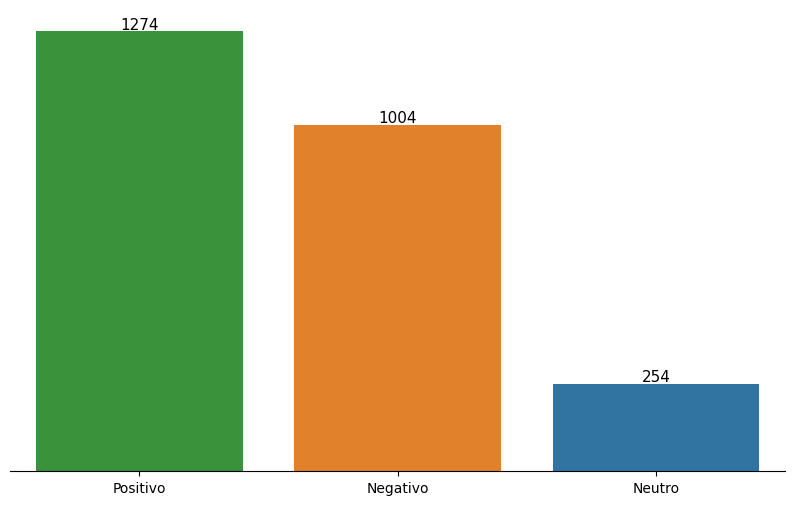

In [36]:
fig, ax = plt.subplots(1, figsize=(10, 6))

sns.barplot(
    data=sentiment_counts,
    x=sentiment_counts.index,
    y="count",
    palette=[
        PlotConfig.POSITIVE_SENTIMENT_COLOR,
        PlotConfig.NEGATIVE_SENTIMENT_COLOR,
        PlotConfig.NEUTRAL_SENTIMENT_COLOR,
    ],
    ax=ax
)

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=11,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.set_xticklabels(["Positivo", "Negativo", "Neutro"])
ax.set_xlabel("")

ax.set_yticks([])
ax.set_ylabel("")


# ax.set_title("Sentiment Distribution predicted by Trained Model")
plt.show()

### Predicted Sentiment by Company

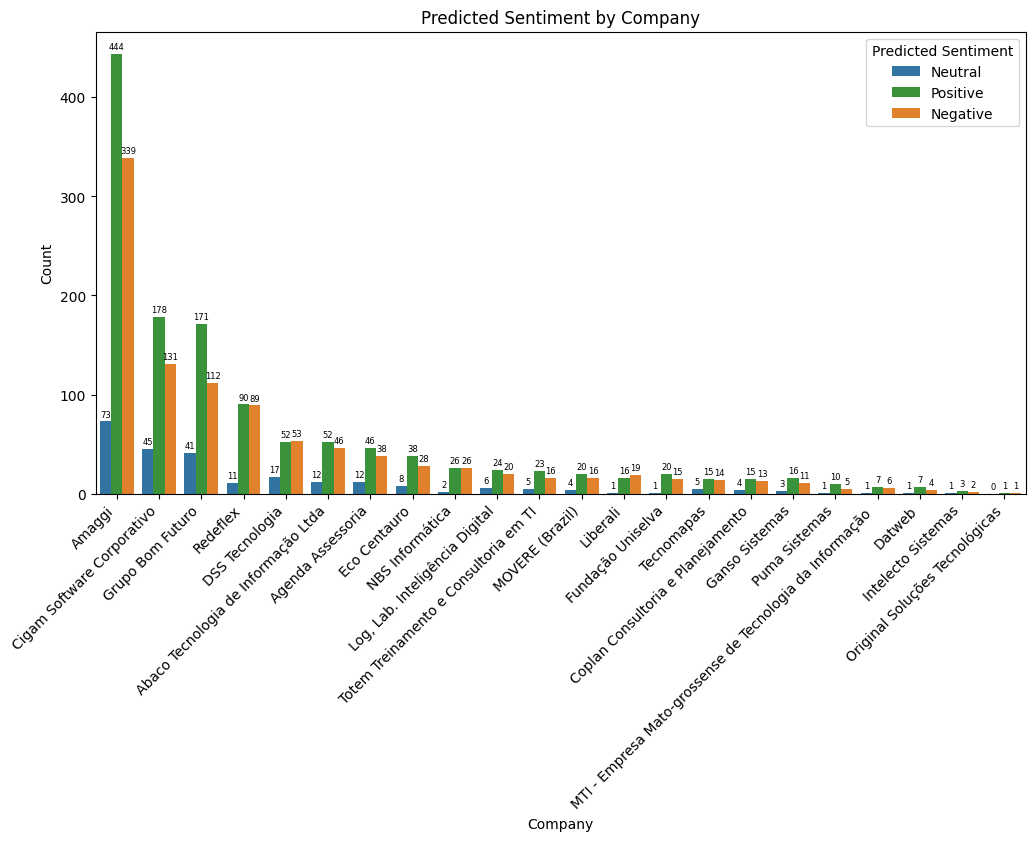

In [37]:
fig, ax = plt.subplots(1, figsize=(12, 6))
sns.countplot(
    data=reviews_df,
    x="company",
    hue="predicted_sentiment",
    order=reviews_df["company"].value_counts().index,
    ax=ax,
    palette=PlotConfig.SENTIMENT_PALETTE,
)

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=6,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.title("Predicted Sentiment by Company")
plt.xlabel("Company")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Predicted Sentiment", labels=PlotConfig.SENTIMENT_DICT.values())
plt.show()

### Predicted Sentiment by Star Rating

In [38]:
warnings.filterwarnings("ignore", "use_inf_as_na")

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\axisgrid.py:181: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


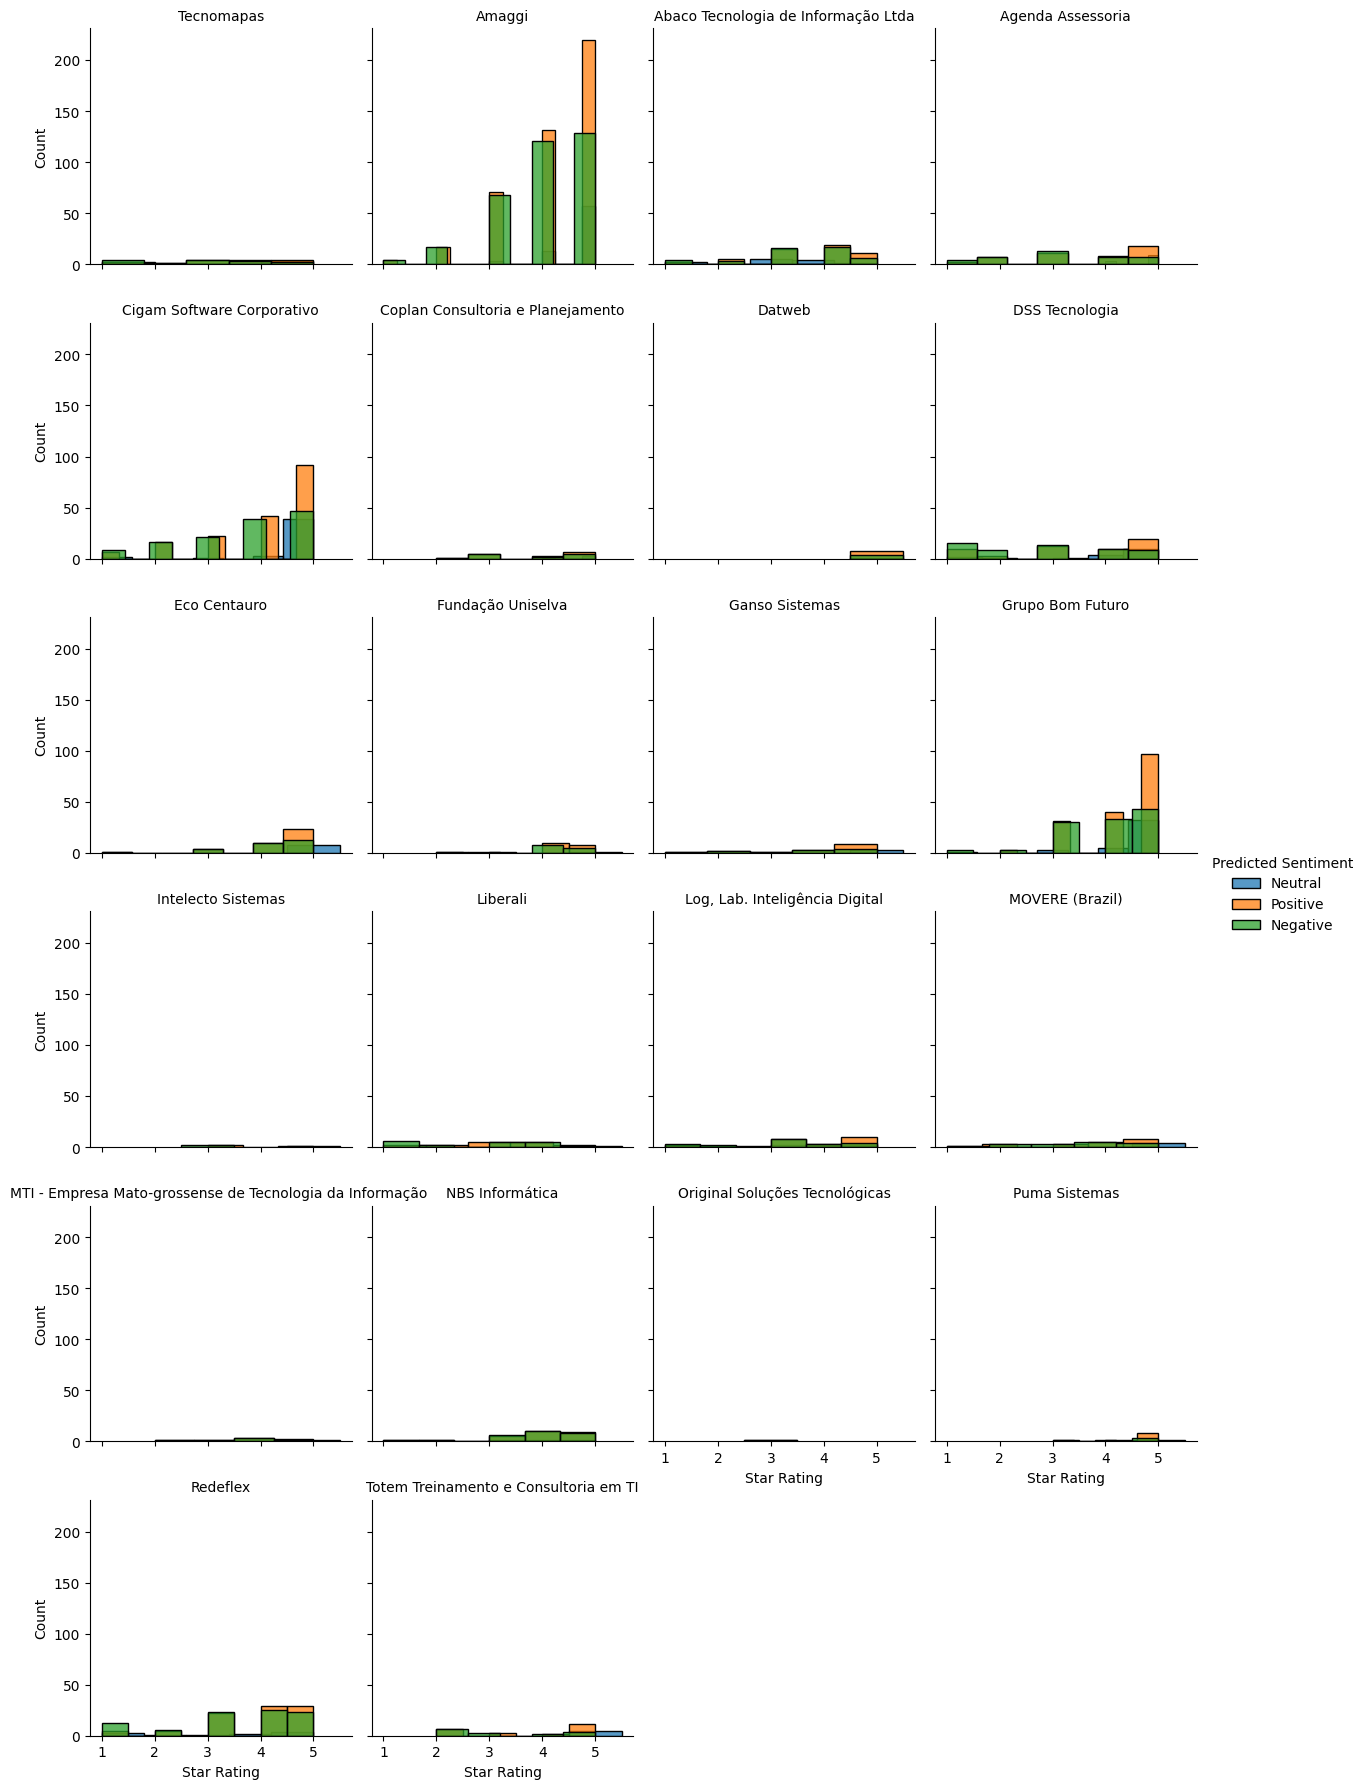

In [39]:
g = sns.FacetGrid(
    reviews_df,
    col="company",
    hue="predicted_sentiment",
    col_wrap=4,
)
g.map(sns.histplot, "star_rating")

g.set_titles("{col_name}")
g.set_axis_labels("Star Rating", "Count")
g.add_legend(
    title="Predicted Sentiment",
    labels=list(PlotConfig.SENTIMENT_DICT.values()),
)

plt.show()

### Predicted Sentiment by Employee Role

In [40]:
desired_company = "Amaggi"
desired_sentiment = 0

In [41]:
reviews_df[reviews_df["company"] == desired_company][
    "predicted_sentiment"
].value_counts()

predicted_sentiment
1    444
2    339
0     73
Name: count, dtype: int64

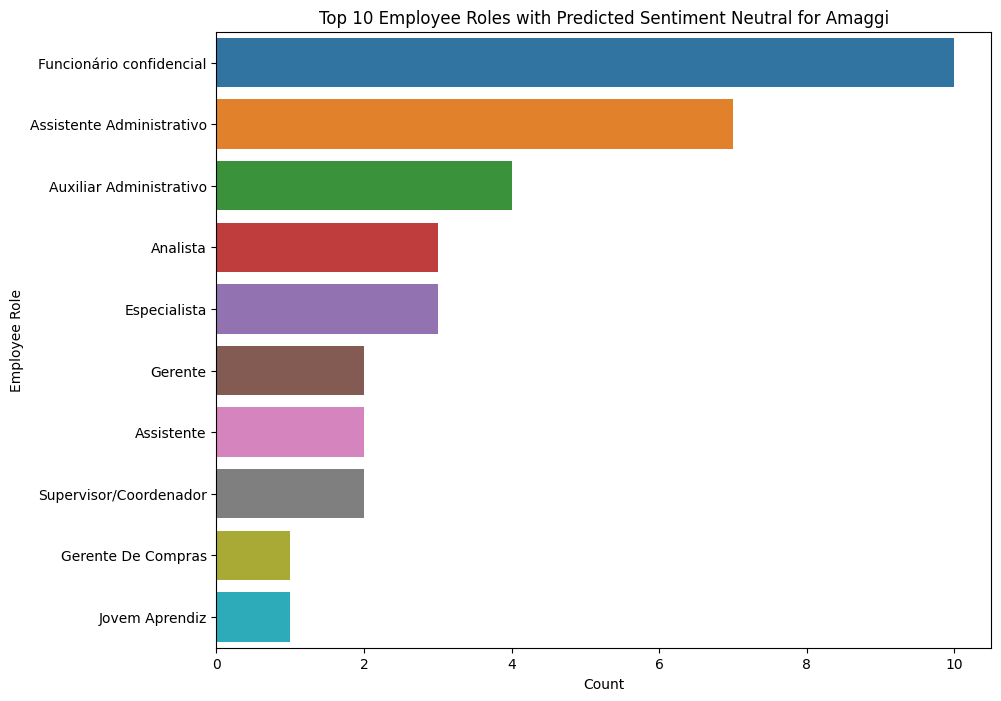

In [42]:
company_df = reviews_df[reviews_df["company"] == desired_company]
filtered_df = company_df[company_df["predicted_sentiment"] == desired_sentiment]
top_10_roles = filtered_df["employee_role"].value_counts().index[:10]
filtered_df = filtered_df[filtered_df["employee_role"].isin(top_10_roles)]

plt.figure(figsize=(10, 8))
sns.countplot(data=filtered_df, y="employee_role", order=top_10_roles)

plt.title(
    f"Top 10 Employee Roles with Predicted Sentiment {PlotConfig.SENTIMENT_DICT[desired_sentiment]} for {desired_company}"
)
plt.xlabel("Count")
plt.ylabel("Employee Role")
plt.show()

## N-Grams per Sentiment

In [43]:
def plot_top_ngrams_barchart(review_text, n_grams=2, top=10, title=None):
    vec = CountVectorizer(ngram_range=(n_grams, n_grams)).fit(review_text)
    bag_of_words = vec.transform(review_text)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    top_n_grams = words_freq[:top]
    x, y = map(list, zip(*top_n_grams))

    fig, ax = plt.subplots(1, figsize=(10, 6))

    sns.barplot(x=y, y=x, ax=ax)

    ax.set_xlabel('Count')
    ax.set_ylabel("Trigram")

    plt.title(
        title,
        fontsize=14,
    )

    plt.show()

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


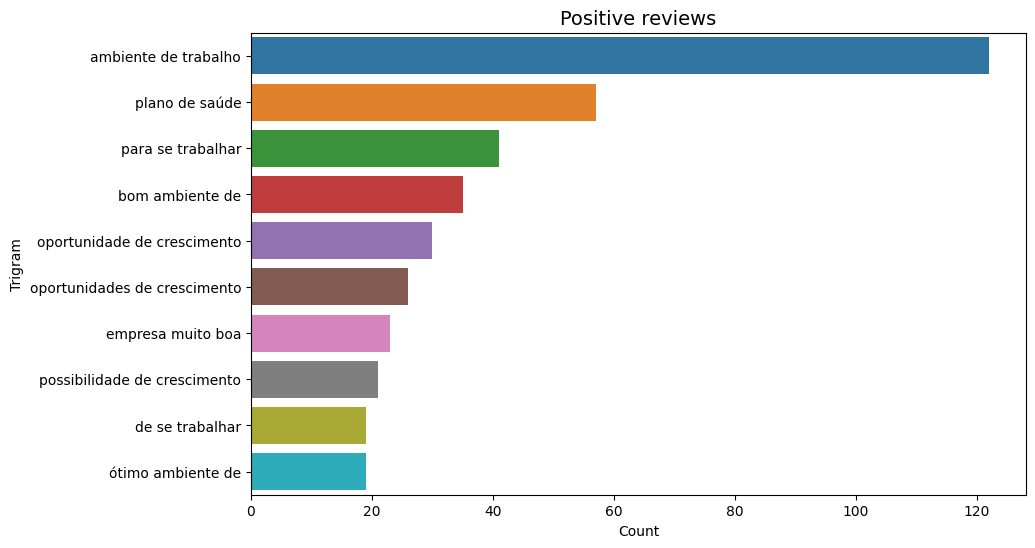

In [44]:
plot_top_ngrams_barchart(
    positive_reviews_df["review_text"],
    n_grams=3,
    top=10,
    title="Positive reviews"
)

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


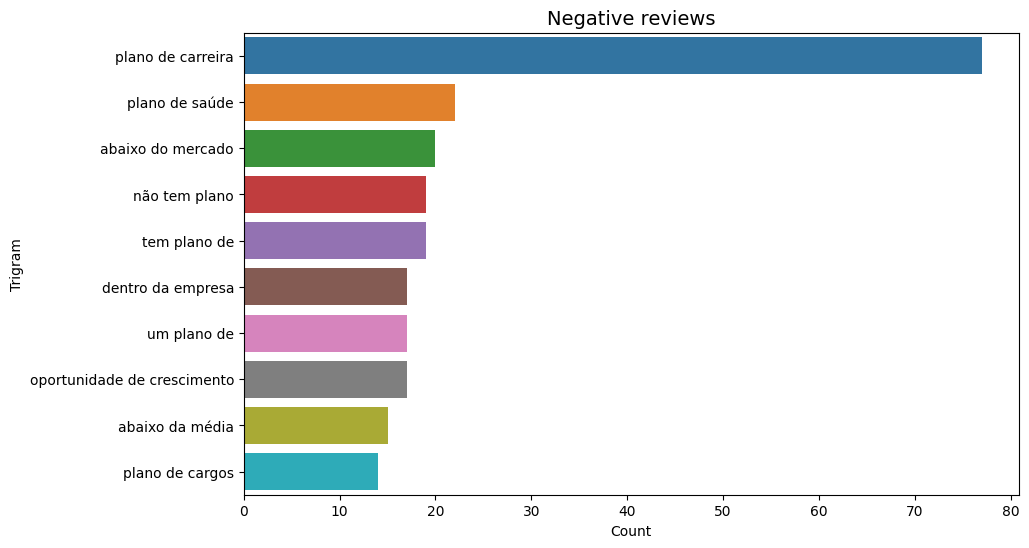

In [45]:
plot_top_ngrams_barchart(
    negative_reviews_df["review_text"], n_grams=3, top=10, title="Negative reviews"
)

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


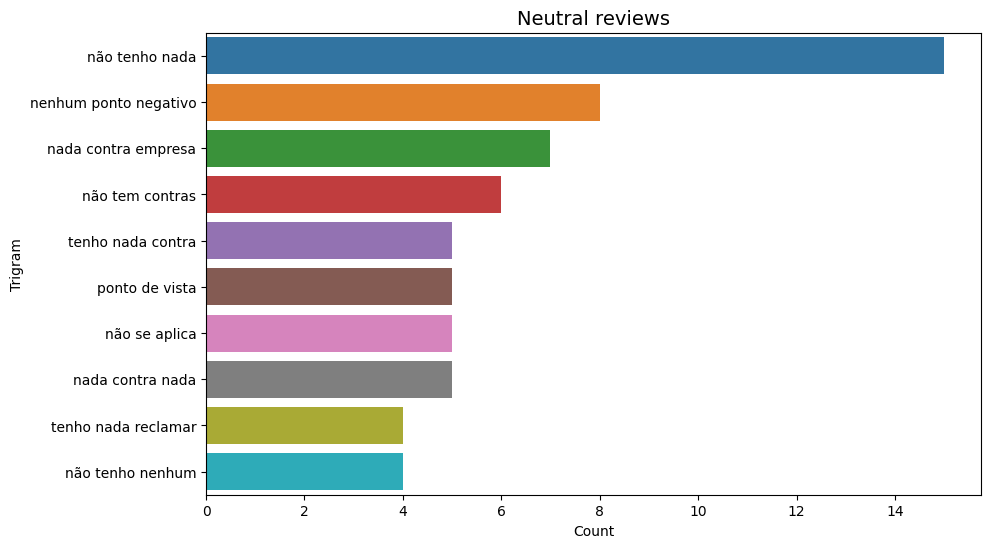

In [46]:
plot_top_ngrams_barchart(
    neutral_reviews_df["review_text"], n_grams=3, top=10, title="Neutral reviews"
)

### All in one

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


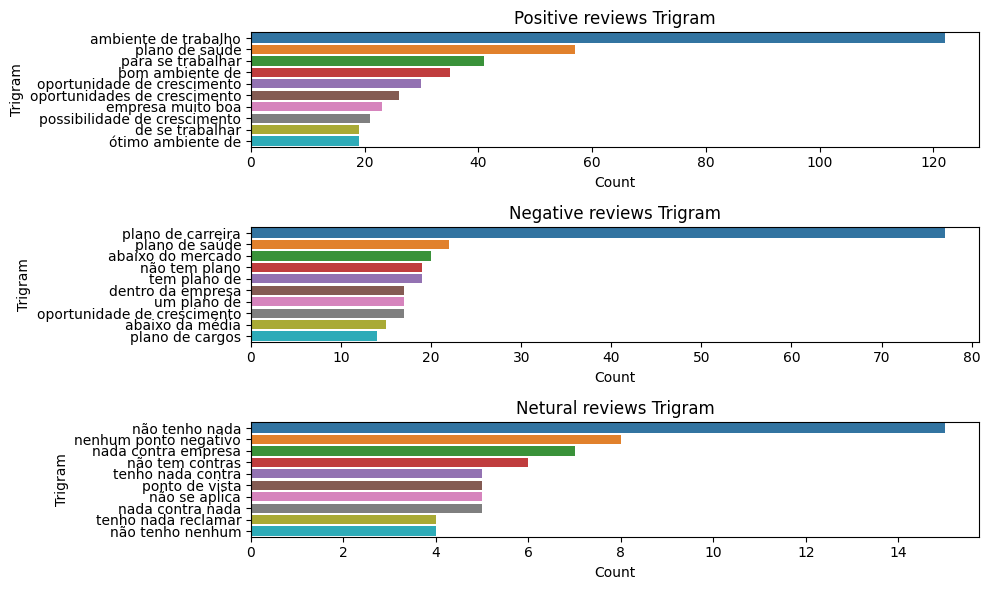

In [47]:
vec_positive = CountVectorizer(ngram_range=(3, 3)).fit(
    positive_reviews_df["review_text"]
)
vec_negative = CountVectorizer(ngram_range=(3, 3)).fit(
    negative_reviews_df["review_text"]
)
vec_neutral = CountVectorizer(ngram_range=(3, 3)).fit(neutral_reviews_df["review_text"])


bag_of_words_positive = vec_positive.transform(positive_reviews_df["review_text"])
bag_of_words_negative = vec_negative.transform(negative_reviews_df["review_text"])
bag_of_words_neutral = vec_neutral.transform(neutral_reviews_df["review_text"])

sum_words_positive = bag_of_words_positive.sum(axis=0)
sum_words_negative = bag_of_words_negative.sum(axis=0)
sum_words_neutral = bag_of_words_neutral.sum(axis=0)

words_freq_positive = [
    (word, sum_words_positive[0, idx]) for word, idx in vec_positive.vocabulary_.items()
]
words_freq_positive = sorted(words_freq_positive, key=lambda x: x[1], reverse=True)

words_freq_negative = [
    (word, sum_words_negative[0, idx]) for word, idx in vec_negative.vocabulary_.items()
]
words_freq_negative = sorted(words_freq_negative, key=lambda x: x[1], reverse=True)

words_freq_neutral = [
    (word, sum_words_neutral[0, idx]) for word, idx in vec_neutral.vocabulary_.items()
]
words_freq_neutral = sorted(words_freq_neutral, key=lambda x: x[1], reverse=True)


top_n_grams_positive = words_freq_positive[:10]
top_n_grams_negative = words_freq_negative[:10]
top_n_grams_neutral = words_freq_neutral[:10]


x_positive, y_positive = map(list, zip(*top_n_grams_positive))
x_negative, y_negative = map(list, zip(*top_n_grams_negative))
x_neutral, y_neutral = map(list, zip(*top_n_grams_neutral))

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))

sns.barplot(x=y_positive, y=x_positive, ax=ax[0])
sns.barplot(x=y_negative, y=x_negative, ax=ax[1])
sns.barplot(x=y_neutral, y=x_neutral, ax=ax[2])

ax[0].set_xlabel("Count")
ax[0].set_ylabel("Trigram")
ax[0].set_title("Positive reviews Trigram")

ax[1].set_xlabel("Count")
ax[1].set_ylabel("Trigram")
ax[1].set_title("Negative reviews Trigram")

ax[2].set_xlabel("Count")
ax[2].set_ylabel("Trigram")
ax[2].set_title("Netural reviews Trigram")

plt.tight_layout()
plt.show()